# Denoising Diffusion Probabilistic Model (DDPM)

$\textbf{Author}$: Soo Min Kwon

This notebook is a tutorial on implementing Denoising Diffusion Probabilistic Model (DDPM). This tutorial is largely a compilation of a lot of tutorials available online. 

## Setup
To help faciliate discussion, let us recall the two steps in a diffusion model process: forward and reverse diffusion.
 - $\textbf{Forward Process}$: We compute $p(x_t | x_{t-1})$ by gradually adding Gaussian noise until we end up with pure noise. We often refer to $p(x_t | x_{t-1})$ as a "transition kernel".
 - $\textbf{Reverse Process}$: We reverse the noise process by computing $p(x_{t-1} | x_t)$, which is approximated by a neural network. Since the forward process returns an image that is pure noise, we start by sampling from a Gaussian.
 
Recall that in the DDPM setting, we work with the Gaussian transition kernel, which is that $p(x_t | x_{t-1})$ is given by

$$
\begin{align}
p(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t} x_{t-1}, \beta_t \mathbf{I}),
\end{align}
$$
where $\beta_t \in (0, 1)$.
 
A nice property of the Gaussian transition kernel is that we can directly compute $p(x_t | x_0)$ by marginalizing the joint distribution:

$$
\begin{align}
p(x_t | x_{0}) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_{0}, (1-\alpha_t) \mathbf{I}),
\end{align}
$$
where $\alpha_t = 1 - \beta_t$ and $\bar{\alpha_t} = \prod_{i=1}^t \alpha_i$.

## Visualizing the Forward Diffusion Process

In this section, we will implement and demonstrate how the forward diffusion process works following the setup described above.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
from torch import nn
import torch.nn.functional as F

We will start by defining a scheduler to compute $\beta_t$. For simplicity, we will use a linear scheduler. The value of $\beta$ will increase as $t$ increases, as we need to add more noise to the images during the forward process.

In [2]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

In [3]:
#beta_start = 0.0001
#beta_end = 0.02
timesteps = 200

# defining beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

# computations for parameters of Gaussian
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

In [4]:
# importing image
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from PIL import Image
image = Image.open("mishu.jpg")

image_size = 128

# transforming each image into a PyTorch tensor with rescaling in [-1, 1]
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into Numpy array of shape (H, W, C), divide by 255
    Lambda(lambda t: (t * 2) - 1),
])

x_start = transform(image).unsqueeze(0)
print('Shape of Starting Image:', x_start.shape)

Shape of Starting Image: torch.Size([1, 3, 128, 128])


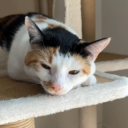

In [5]:
# transforming an image from [-1, 1] back to a uint8 image
reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

reverse_transform(x_start.squeeze())

In [6]:
def extract(a, t, x_shape):
    """
    Helper function to retrieve certain value of noise (alpha) from indexed t.
    
    Arguments:
        a:         PyTorch tensor of alpha values.
        t:         PyTorch tensor of the time index.
        x_shape:   Shape of the image 'x'
        
    """
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [7]:
def q_sample(x_start, t, noise=None):
    """
    Function to obtain p(x_t | x_0) following the setup above.
    
    Arguments:
        x_start:                         Starting image x_0
        t:                               Time sample 't'
        sqrt_alphas_cum_prod:            \sqrt{\bar{alpha}_t}              
        sqrt_one_minus_alphas_cumprod    \sqrt{(1 - \bar{alpha}_t)}
        noise:                           Noise (default is Gaussian)
    """

    # base case
    if noise is None:
        noise = torch.randn_like(x_start) # generating a Gaussian N(0, I) with dimensions as x_start

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [8]:
def get_noisy_image(x_start, t):
    """
    Function to obtain noisy image p(x_t | x_0) given time t.
    
    Arguments:
        x_start:   Starting image x_0
        t:         Time sample 't'
    """

    x_noisy = q_sample(x_start=x_start, t=t) # add noise
    noisy_image = reverse_transform(x_noisy.squeeze()) # turn back into PIL image

    return noisy_image

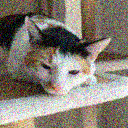

In [9]:
# running noisy image example
t = torch.tensor([30])
get_noisy_image(x_start, t)


In [10]:
def plot_sequence_images(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    """
    Function to plot a sequence of images to demonstrate the forward diffusion process.
    """
    
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [11]:
plot_sequence_images([get_noisy_image(x_start, torch.tensor([t])) for t in [1, 50, 150, 199]])

## Reverse Process

Recall that in the reverse process, the objective is to start from a noise distribution to estimate $p(x_{t-1}|x_t)$. With the Gaussian transition kernel, given that $\beta$ is small enough, we have that $p(x_{t-1}|x_t) = \mathcal{N}(\tilde{\mu}(x_t), \tilde{\sigma}(x_t))$. However, these parameters $\tilde{\mu}(x_t)$ and $\tilde{\sigma}(x_t)$ are not computable, as that would require us knowing to true data distribution $p(x_0)$. What we can do instead is $\textbf{use a neural network to learn the parameters $\tilde{\mu}(x_t)$ and $\tilde{\sigma}(x_t)$} $.

Suppose that we substitute $\tilde{\sigma}(x_t)$ with a time dependent constant $\tilde{\beta}_t$, where $\tilde{\beta}_t$ is

$$
\begin{align}
    \tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1-\bar{\alpha}_t} \beta_t.
\end{align}
$$

Then, conditioning on $x_0$, we have that $p(x_{t-1} | x_t, x_0) = \mathcal{N}(\tilde{\mu}(x_t, x_0), \tilde{\beta}_t) = \mathcal{N}(\tilde{\mu}_t, \tilde{\beta}_t)$, where

$$
\begin{align}
    \tilde{\mu}_t = \frac{1}{\sqrt{\alpha_t}} \left(x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \tilde{z}_t \right).
\end{align}
$$

Lastly, using Bayes rule and some algebra with the definition of a Gaussian PDF, we have that
$$
\begin{align}
    \tilde{\beta}_t &= \frac{1 - \bar{\alpha}_{t-1}}{1-\bar{\alpha}_t} \beta_t \\
    \tilde{\mu}_t &= \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \alpha_t}} z_t \right).
\end{align}
$$

Since we do not know what $z_t$ is, we want to use a neural network to approximate $z_t$. That is, given a noisy image $x_t$, the neural network will predict what $z_t$ is so that we can approximate $x_{t-1} = x_t - z_t$. The neural network commonly used in this framework is a U-Net.

### Loss Function

Now that we have everything at our fingertips, what is the loss function for our reverse process? Let $z_{t-1}$ be the noise vector injected to obtain $x_t$ from $x_{t-1}$, and let $\tilde{z}_{t}$ be the estimated noise from the NN (i.e. the noise vector to get from $x_{t-1}$ to $x_t$). We want to minimize the difference between $z_{t-1}$ and $\tilde{z}_{t}$, so a suitable loss can be

$$
\begin{align}
    \| z_{t-1} - NN(x_t, t) \|_2.
\end{align}
$$


Putting everything together, we have the following algorithm:
- Sample an image from the training data $x_0 \sim p(x_0)$
- Sample $z$ and $t$ randomly from $z \sim \mathcal{N}(0, \mathbf{I})$ and $t \sim U([1, T])$, respectively
- Take gradient step $\nabla_\theta \| z_{t-1} - NN_{\theta}(x_t, t) \|_2$


In [12]:
def p_losses(denoise_model, x_start, t):
    """
    Given x_0 and t, this function generates x_t and finds the MSE between x_t and x_noisy.
    """

    # random sample z    
    noise = torch.randn_like(x_start)
    
    # compute x_t
    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    
    # recover z from x_t
    predicted_noise = denoise_model(x_noisy, t)

    return F.smooth_l1_loss(noise, predicted_noise)

In [13]:
# calculations for posterior q(x_{t-1} | x_t, x_0) = q(x_{t-1} | t, x_0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [14]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    """
    Function to sample p(x_{t-1} | x_t)
    """

    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # x_{t-1}
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

In [15]:
# sampling loop
@torch.no_grad()
def p_sample_loop(model, shape):
    """
    Function to sample x_0 from x_T, iteratively.
    """
    device = next(model.parameters()).device

    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((shape[0],), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

## Example: Generating MNIST

In this example, we will use the MNIST dataset to test out our implementation of DDPM. We will load in MNIST using the datasets package:
- pip install datasets[visual]

In [16]:
from datasets import load_dataset

dataset = load_dataset("mnist")
image_size = 28
channels = 1
batch_size = 128


Found cached dataset mnist (/Users/soominkwon/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4)


  0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
from torchvision import transforms
from torch.utils.data import DataLoader

# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
    examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
    del examples["image"]

    return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)

In [18]:
from unet import Unet
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

In [19]:
from torchvision.utils import save_image

epochs = 5

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        batch_size = batch["pixel_values"].shape[0]
        batch = batch["pixel_values"].to(device)

        # sample t from U(0,T)
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        loss = p_losses(model, batch, t)

        if step % 100 == 0:
            print("Loss:", loss.item())

        loss.backward()
        optimizer.step()

Loss: 0.48469242453575134
Loss: 0.12314128875732422
Loss: 0.0704321339726448
Loss: 0.05555141344666481
Loss: 0.04900192841887474
Loss: 0.03828192129731178
Loss: 0.04063381999731064
Loss: 0.036385685205459595
Loss: 0.03443238139152527
Loss: 0.03278624638915062
Loss: 0.03444996848702431
Loss: 0.029863737523555756
Loss: 0.03193283826112747
Loss: 0.027790497988462448
Loss: 0.028985969722270966
Loss: 0.03086310438811779
Loss: 0.02757754549384117
Loss: 0.03181565925478935
Loss: 0.028431668877601624
Loss: 0.03043363057076931
Loss: 0.026861732825636864
Loss: 0.031157158315181732
Loss: 0.029596878215670586
Loss: 0.025164419785141945
Loss: 0.025733429938554764


In [23]:
# sample 64 images
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

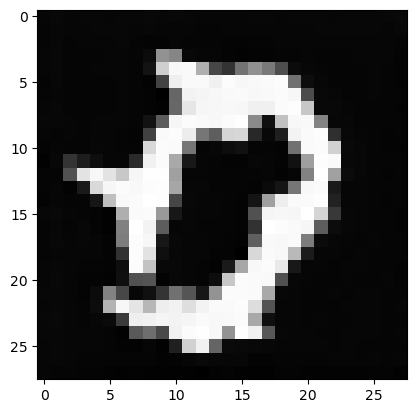

In [28]:
# display a random image
random_index = 15
%matplotlib inline
plt.imshow(samples[-1][random_index].reshape(image_size, image_size), cmap="gray")